2. Utilizarem métodos estatísticos para mostrar que o PowerCap aumento o tempo de execução em cada benchmark estudado.

In [2]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
file_name = '../measurements_haskell.csv'
df = pd.read_csv(file_name)

# Display the first few rows of the DataFrame
print("BASIC STATS")
print("###### First few rows of the dataset:")
print(df.head())

# Display basic statistics of the dataset
print("\n\n ###### Basic statistics of the dataset:")
print(df.describe())

# Check for any missing values
print("\n\n ###### Missing values in each column:")
print(df.isnull().sum())

# Display the data types of each column
print("\n\n ###### Data types of each column:")
print(df.dtypes)

BASIC STATS
###### First few rows of the dataset:
  Language     Program  PowerLimit    Package       Core GPU DRAM  Time  \
0  Haskell   real/grep          -1  72.903320  65.487793           2967   
1  Haskell   real/grep          -1  72.392822  64.819519           2950   
2  Haskell   real/grep          -1  75.767273  67.646912           3108   
3  Haskell   real/grep          -1  73.907654  66.416260           2954   
4  Haskell   real/grep          -1  74.116394  66.502380           2968   

   Temperature  Memory  
0         45.1    5920  
1         47.3    6240  
2         49.1    6080  
3         49.0    6080  
4         50.8    6080  


 ###### Basic statistics of the dataset:
       PowerLimit     Package        Core          Time  Temperature  \
count  600.000000  600.000000  600.000000    600.000000   600.000000   
mean    34.833333   79.968531   65.439080   5815.533333    47.456167   
std     39.446998   36.868270   35.433136   3792.926025     5.360222   
min     -1.000000 

In [4]:
df = df[['Program', 'PowerLimit', 'Time']]

df.head()

,Program,PowerLimit,Time
0,real/grep,-1,2967
1,real/grep,-1,2950
2,real/grep,-1,3108
3,real/grep,-1,2954
4,real/grep,-1,2968


In [5]:
print(df.groupby("Program")[["PowerLimit", "Time"]].describe())

                         PowerLimit                                        \
                              count       mean        std  min  25%   50%   
Program                                                                     
 imaginary/rfib                60.0  34.833333  39.746726 -1.0  5.0  22.5   
 real/compress                 60.0  34.833333  39.746726 -1.0  5.0  22.5   
 real/compress2                60.0  34.833333  39.746726 -1.0  5.0  22.5   
 real/gg                       60.0  34.833333  39.746726 -1.0  5.0  22.5   
 real/grep                     60.0  34.833333  39.746726 -1.0  5.0  22.5   
 real/rsa                      60.0  34.833333  39.746726 -1.0  5.0  22.5   
 shootout/binary-trees         60.0  34.833333  39.746726 -1.0  5.0  22.5   
 shootout/fannkuch-redux       60.0  34.833333  39.746726 -1.0  5.0  22.5   
 shootout/spectral-norm        60.0  34.833333  39.746726 -1.0  5.0  22.5   
 spectral/sorting              60.0  34.833333  39.746726 -1.0  5.0  22.5   

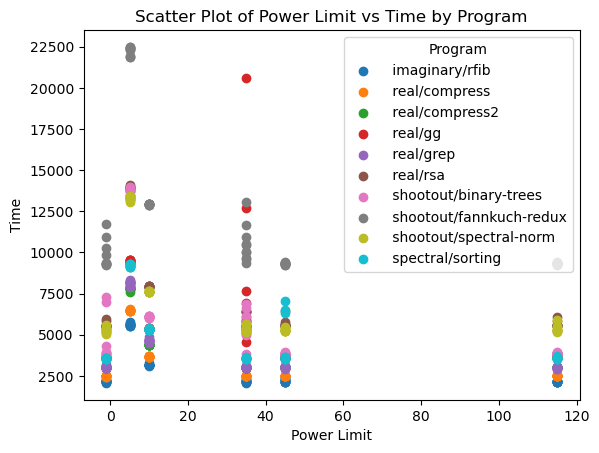

In [6]:
# Create scatter plots for each group
groups = df.groupby('Program')


for name, group in groups:
    plt.scatter(group['PowerLimit'], group['Time'], label=name)

plt.xlabel('Power Limit')
plt.ylabel('Time')
plt.title('Scatter Plot of Power Limit vs Time by Program')
plt.legend(title='Program')
plt.show()


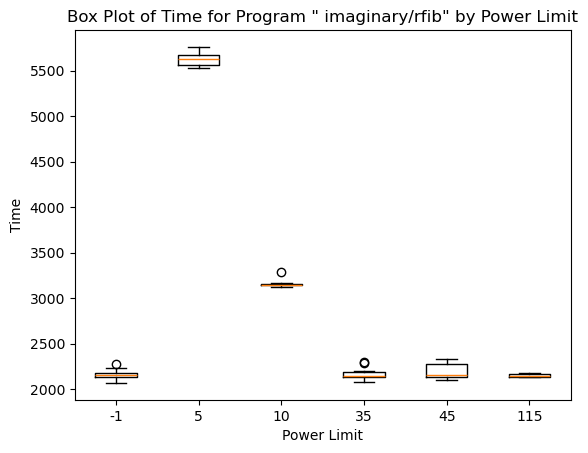

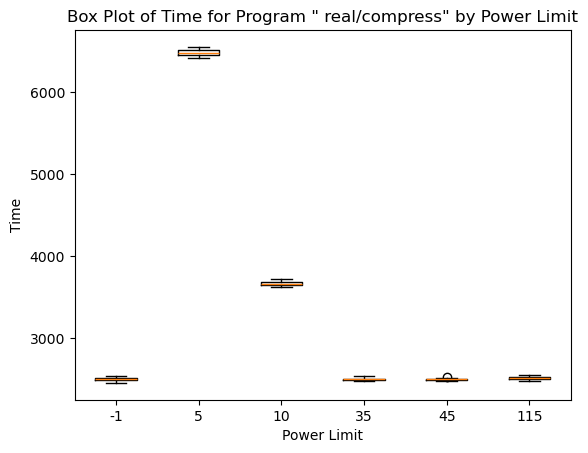

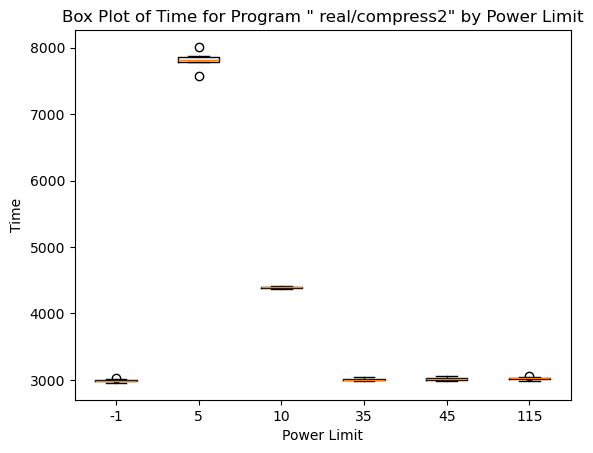

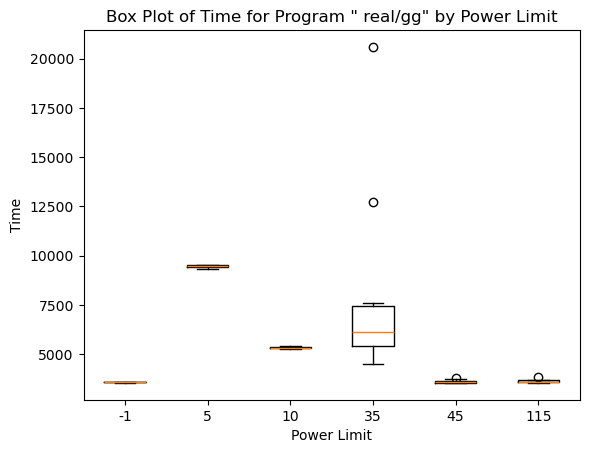

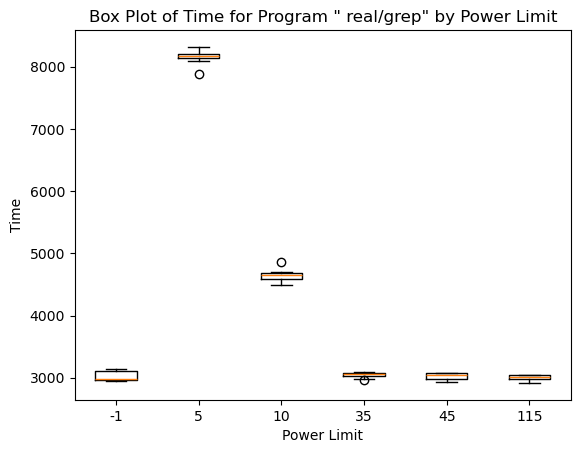

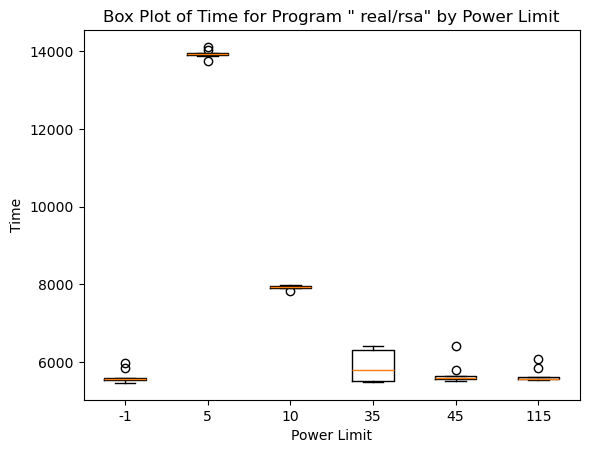

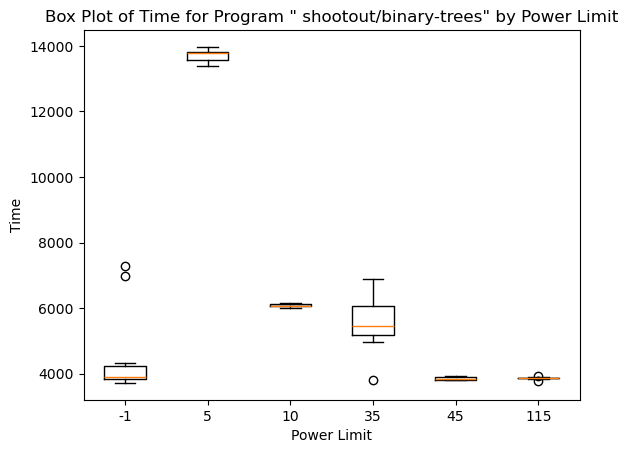

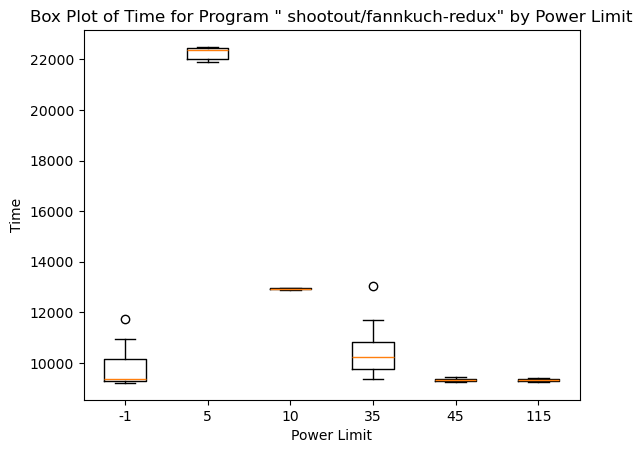

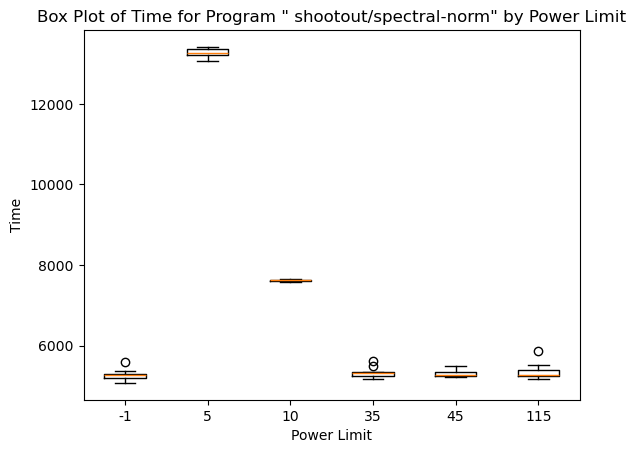

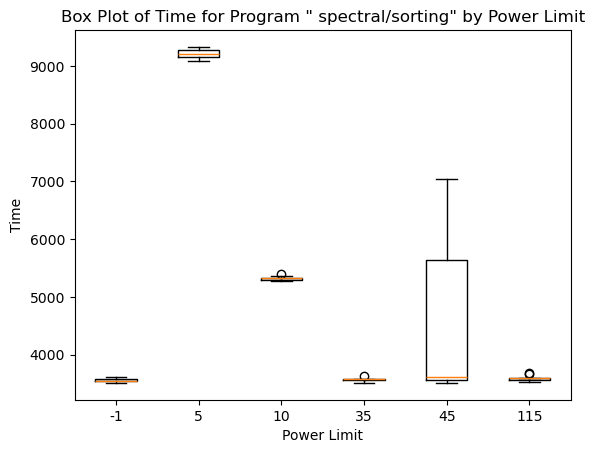

In [7]:

# Iterate over each program group

def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Time'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Time')
        plt.title(f'Box Plot of Time for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [8]:
## REMOVE OUTLIERS in each group (grouped by program and power limit)

grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
cleaned_df2 = cleaned_df.groupby(['Program'])
print(cleaned_df.count())


Program       559
PowerLimit    559
Time          559
dtype: int64


                          PowerLimit  Time
Program                                   
 imaginary/rfib                   60    60
 real/compress                    60    60
 real/compress2                   60    60
 real/gg                          60    60
 real/grep                        60    60
 real/rsa                         60    60
 shootout/binary-trees            60    60
 shootout/fannkuch-redux          60    60
 shootout/spectral-norm           60    60
 spectral/sorting                 60    60
Program       559
PowerLimit    559
Time          559
dtype: int64
                          PowerLimit  Time
Program                                   
 imaginary/rfib                   56    56
 real/compress                    59    59
 real/compress2                   56    56
 real/gg                          56    56
 real/grep                        57    57
 real/rsa                         50    50
 shootout/binary-trees            55    55
 shootout/fannkuch-redux      

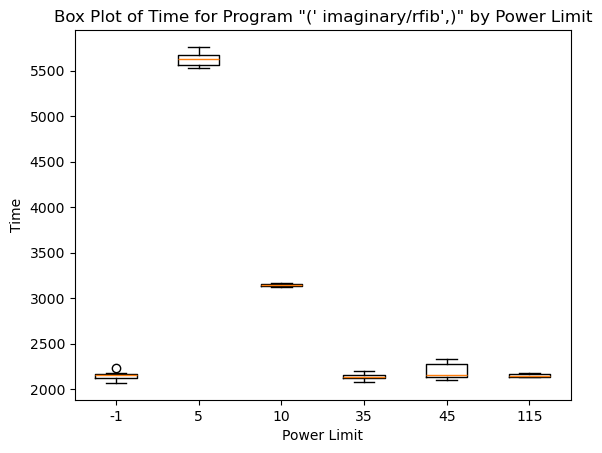

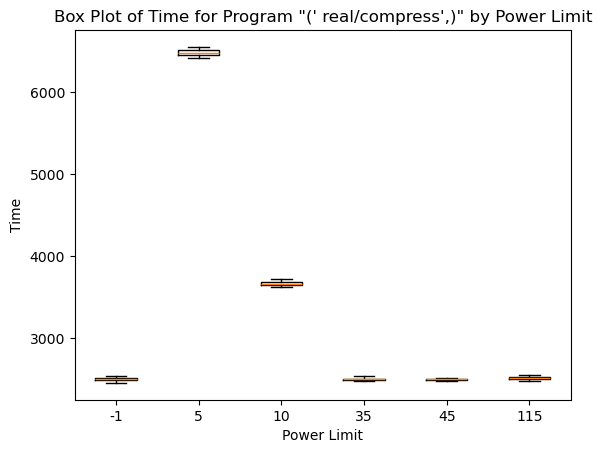

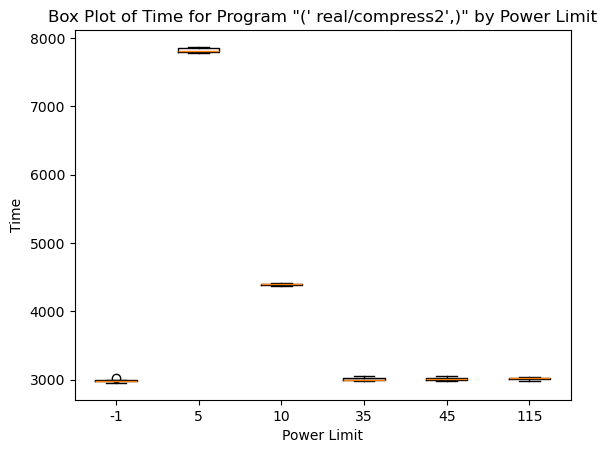

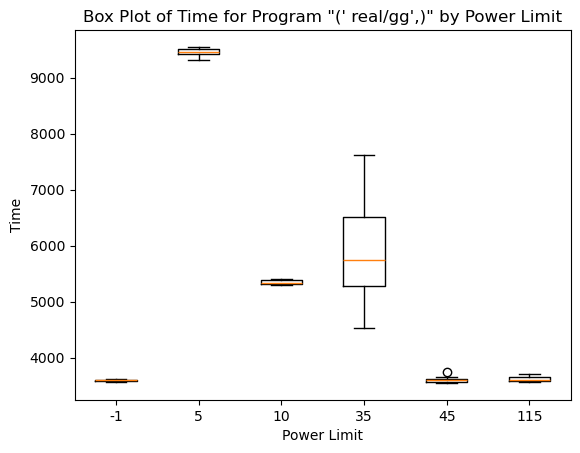

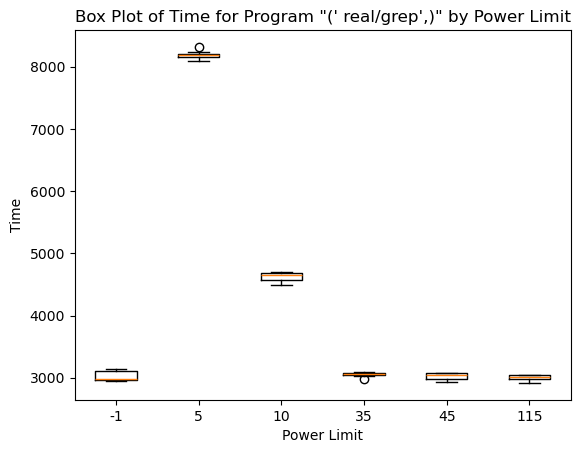

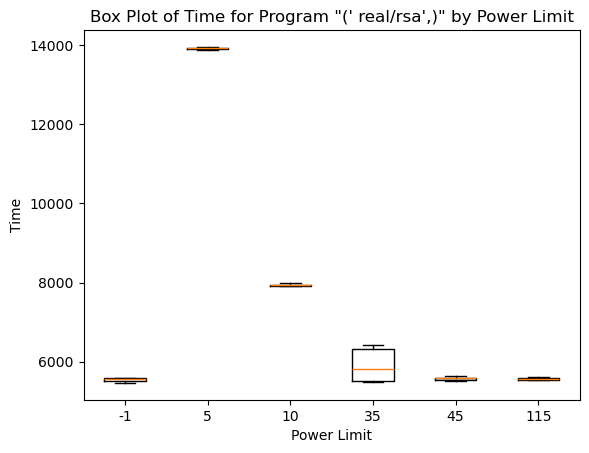

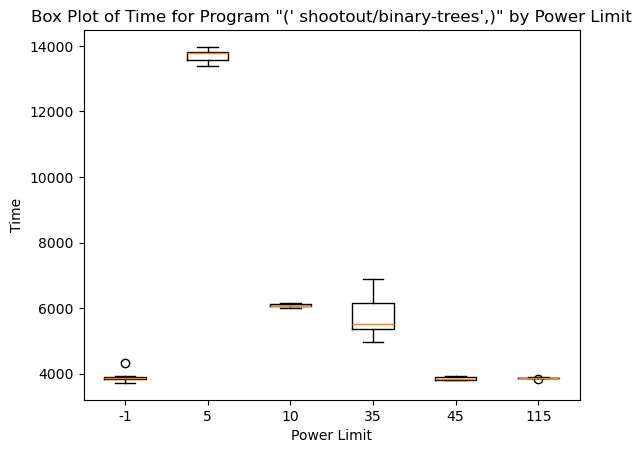

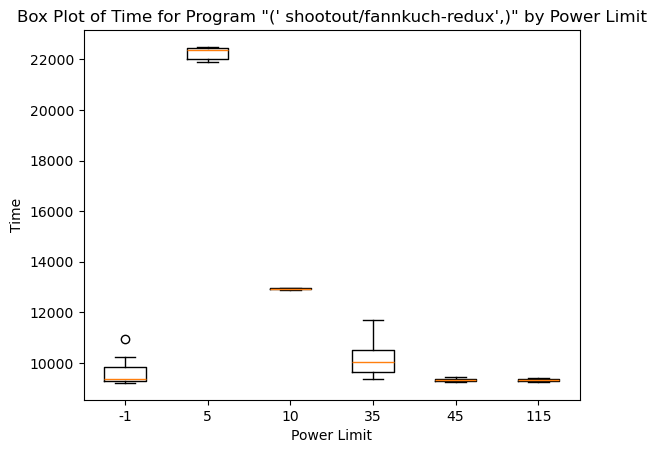

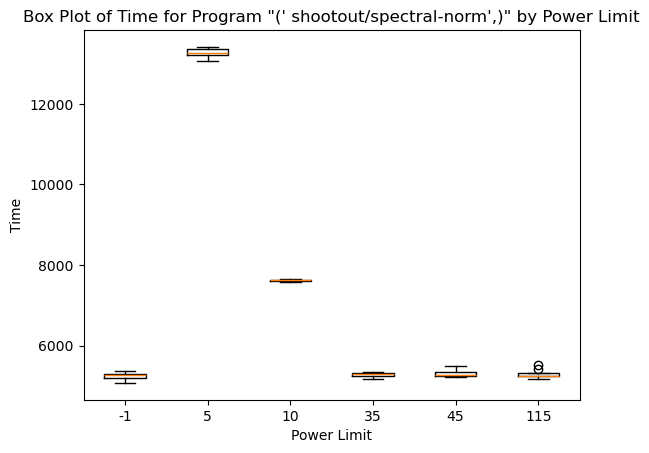

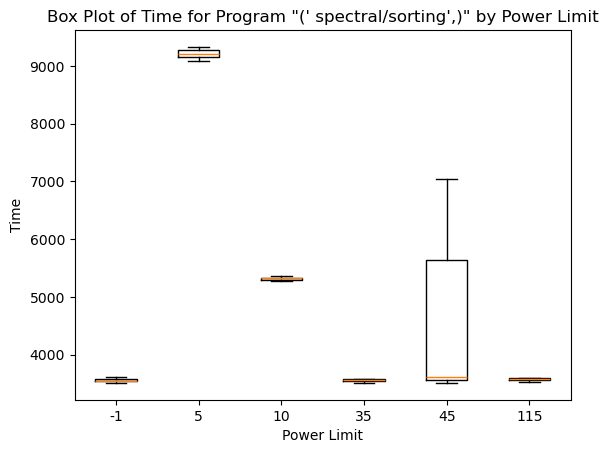

In [9]:
print(groups.count())
print(cleaned_df.count())
print(cleaned_df2.count())

show_box_plot(cleaned_df2)

In [10]:
def calculate_correlations(group):
    # Pearson correlation
    pearson_corr, pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # Kendall Tau correlation
    kendall_corr, kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [pearson_corr],
        'Pearson_p': [pearson_p],
        'Spearman': [spearman_corr],
        'Spearman_p': [spearman_p],
        'Kendall': [kendall_corr],
        'Kendall_p': [kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

                    Program   Pearson     Pearson_p  Spearman    Spearman_p  \
0            imaginary/rfib -0.619736  3.399128e-06 -0.762414  4.761172e-10   
1             real/compress -0.605655  4.009439e-06 -0.740572  1.182101e-09   
2            real/compress2 -0.583656  1.661145e-05 -0.703957  3.386223e-08   
3                   real/gg -0.667350  4.079684e-07 -0.859102  2.192666e-14   
4                 real/grep -0.617411  3.787592e-06 -0.874752  9.317308e-16   
5                  real/rsa -0.589905  3.934330e-05 -0.822290  2.426276e-11   
6     shootout/binary-trees -0.616114  4.021767e-06 -0.892823  3.405101e-17   
7   shootout/fannkuch-redux -0.623484  1.706813e-06 -0.914660  4.091015e-20   
8    shootout/spectral-norm -0.614130  4.406050e-06 -0.801716  1.275885e-11   
9          spectral/sorting -0.608822  7.142516e-06 -0.696073  7.838895e-08   

    Kendall     Kendall_p  
0 -0.608433  2.623789e-08  
1 -0.573197  8.287650e-08  
2 -0.546353  5.951941e-07  
3 -0.677439  9.135

### Correlation Analysis between `PowerLimit` &&  `Time`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was apllied.

#### Program: imaginary/rfib

1. **Pearson**: -0.619736, p-value = 3.399128e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.762414, p-value = 4.761172e-10
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.608433, p-value = 2.623789e-08
    - Moderate negative association, statistically significant.

#### Program: real/compress

1. **Pearson**: -0.605655, p-value = 4.009439e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.740572, p-value = 1.182101e-09
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.573197, p-value = 8.287650e-08
    - Moderate negative association, statistically significant.

#### Program: real/compress2

1. **Pearson**: -0.583656, p-value = 1.661145e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.703957, p-value = 3.386223e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.546353, p-value = 5.951941e-07
    - Moderate negative association, statistically significant.

#### Program: real/gg

1. **Pearson**: -0.667350, p-value = 4.079684e-07
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.859102, p-value = 2.192666e-14
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.677439, p-value = 9.135221e-10
    - Strong negative association, statistically significant.

#### Program: real/grep

1. **Pearson**: -0.617411, p-value = 3.787592e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.874752, p-value = 9.317308e-16
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.743782, p-value = 9.721644e-12
    - Strong negative association, statistically significant.

#### Program: real/rsa

1. **Pearson**: -0.589905, p-value = 3.934330e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.822290, p-value = 2.426276e-11
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.691919, p-value = 2.374662e-09
    - Strong negative association, statistically significant.

#### Program: shootout/binary-trees

1. **Pearson**: -0.616114, p-value = 4.021767e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.892823, p-value = 3.405101e-17
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.739418, p-value = 1.248874e-11
    - Strong negative association, statistically significant.

#### Program: shootout/fannkuch-redux

1. **Pearson**: -0.623484, p-value = 1.706813e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.914660, p-value = 4.091015e-20
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.792452, p-value = 1.145026e-13
    - Strong negative association, statistically significant.

#### Program: shootout/spectral-norm

1. **Pearson**: -0.614130, p-value = 4.406050e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.801716, p-value = 1.275885e-11
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.643448, p-value = 3.800222e-09
    - Strong negative association, statistically significant.

#### Program: spectral/sorting

1. **Pearson**: -0.608822, p-value = 7.142516e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.696073, p-value = 7.838895e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.544260, p-value = 8.567240e-07
    - Moderate negative association, statistically significant.

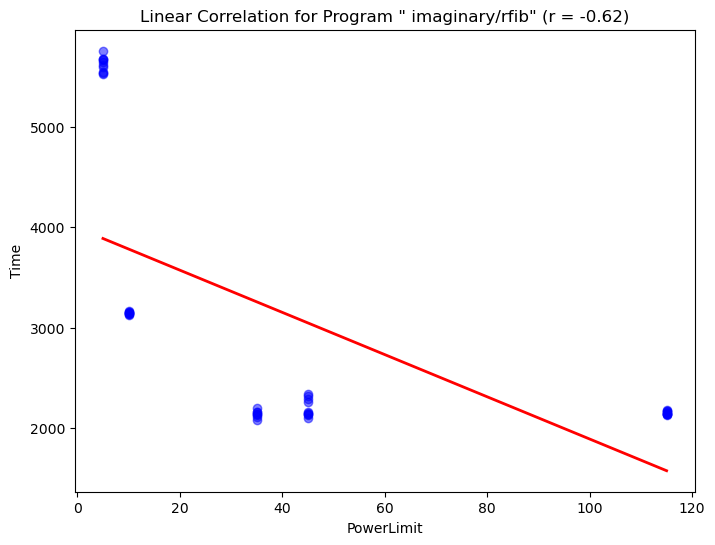

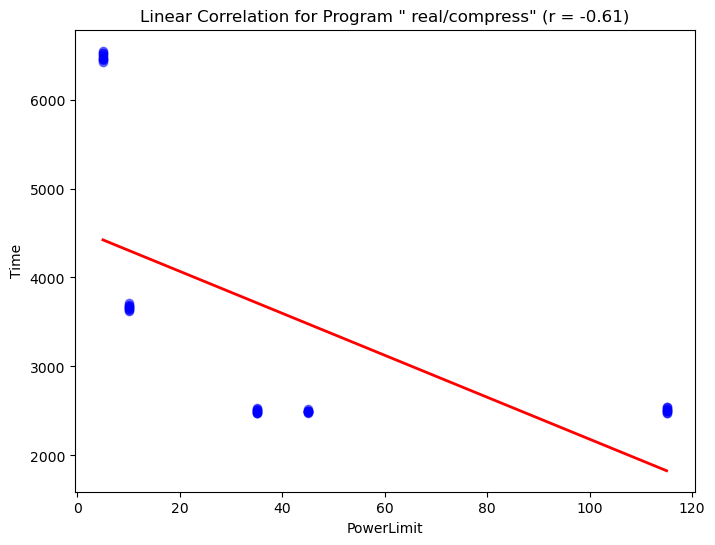

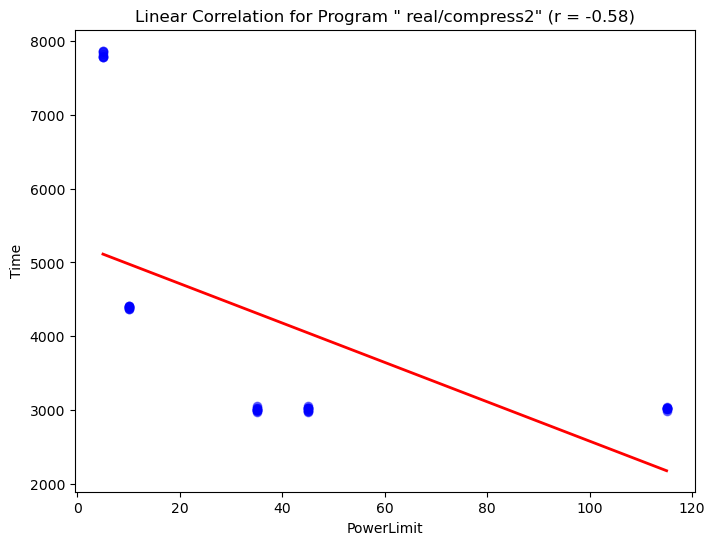

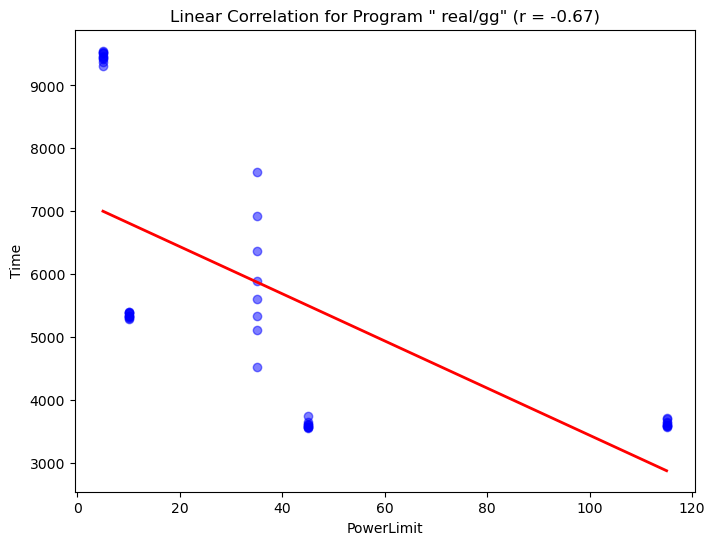

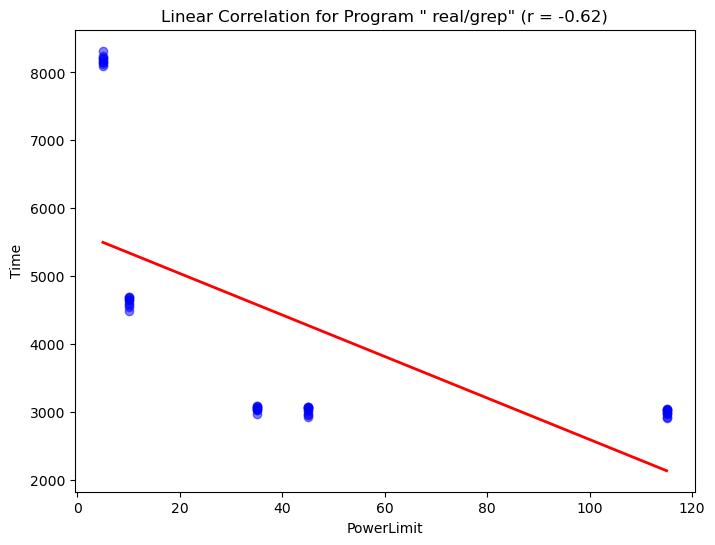

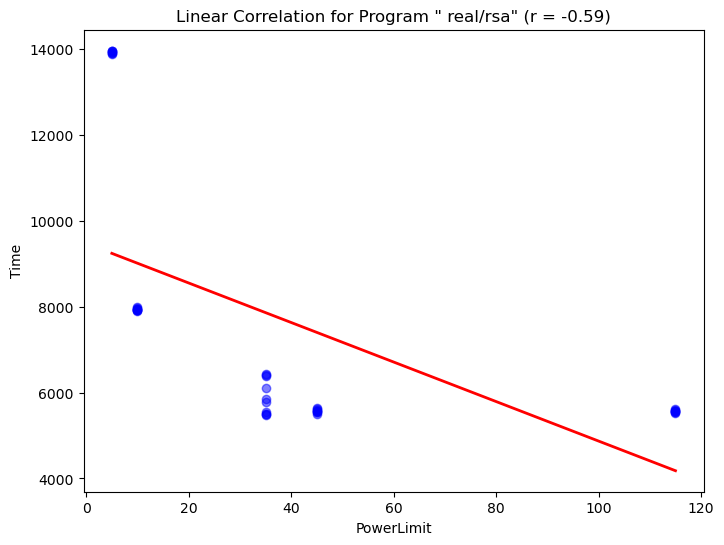

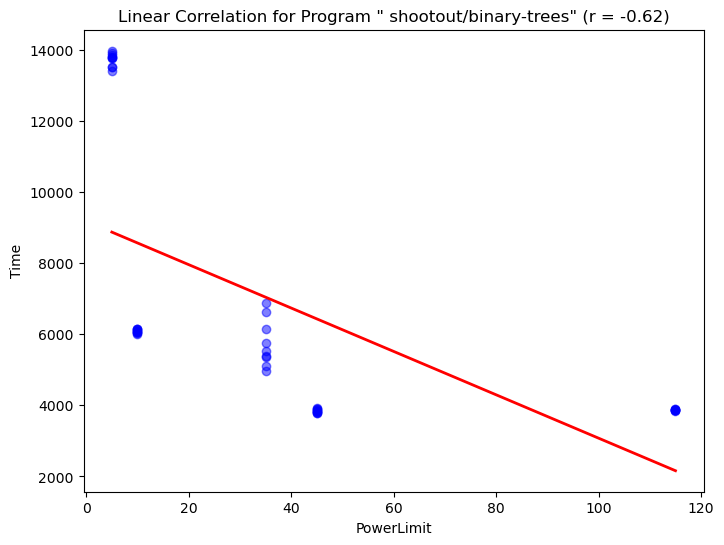

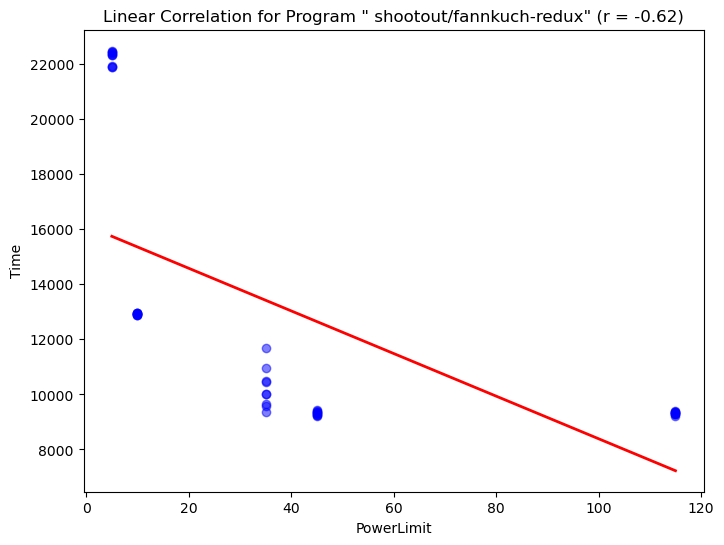

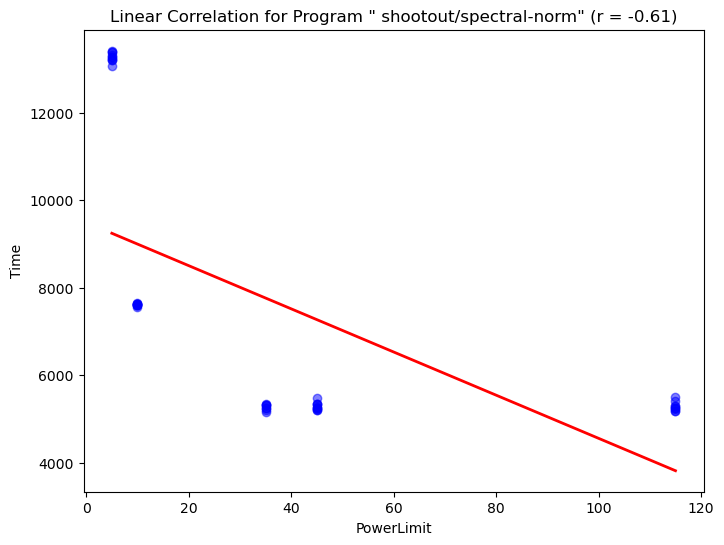

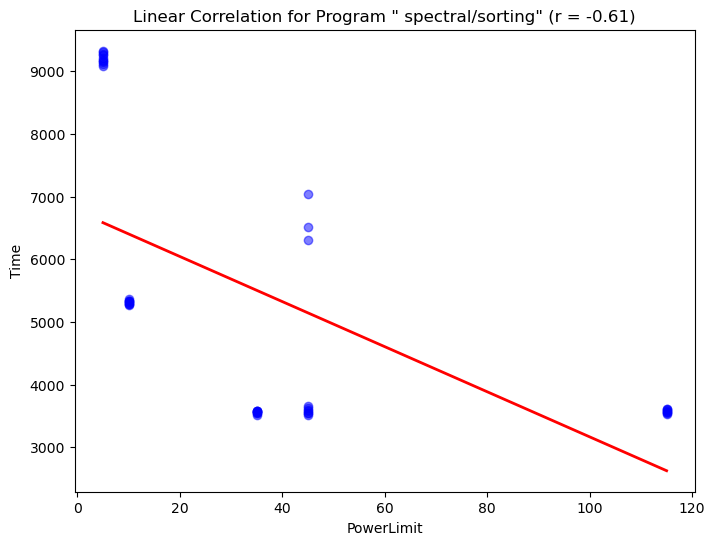

In [11]:
def show_correlation_plot(groups):
    for name, program_group in groups:
        # Calculate correlation for the current program group
        pearson_corr, pearson_p = stats.pearsonr(program_group['Time'], program_group['PowerLimit'])

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Time'], color='blue', alpha=0.5)

        # Add the linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Time'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Time')
        plt.title('Linear Correlation for Program "{}" (r = {:.2f})'.format(name, pearson_corr))
        plt.show()

# Assuming 'groups' is already defined elsewhere
show_correlation_plot(cleaned_df3.groupby('Program'))

## Conclusion

When the Powerlimit grows the execution time lowers in each benchmark, proven by the negative linear relationship between variables. 

This proves the initial hypothesis that Powercap caps the performance of the CPU which makes us conclude that the lower the value in the Powerlimit the higher the power limitation.